### Recommender system algorithm on MovieLens Dataset:

Finding similarity data point:
1) Euclidean distance score
2) pearson correlation score

In [4]:
#step1: importing packages
from math import sqrt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

#step2: getting more than one output line
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [5]:
#step3: loading the dataset using pandas packages and review some of them
movies=pd.read_csv('movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings=pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [7]:
tags=pd.read_csv('tags.csv')
tags.head()

,userId,movieId,tag,timestamp
0,15,339,sandra 'boring' bullock,1138537770
1,15,1955,dentist,1193435061
2,15,7478,Cambodia,1170560997
3,15,32892,Russian,1170626366
4,15,34162,forgettable,1141391765


In [8]:
#step4: deleting the timestamp colums(unnecessary)
del tags['timestamp']

In [9]:
tags.head()

,userId,movieId,tag
0,15,339,sandra 'boring' bullock
1,15,1955,dentist
2,15,7478,Cambodia
3,15,32892,Russian
4,15,34162,forgettable


In [10]:
#step5: get 'descriptive stastistics' on movies dataset
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
movieId    9125 non-null int64
title      9125 non-null object
genres     9125 non-null object
dtypes: int64(1), object(2)
memory usage: 213.9+ KB


In [11]:
ratings['rating'].describe(include='all')

count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

rating
0.5     868
1.0    1959
1.5    1204
2.0    3130
2.5    2409
3.0    4771
3.5    3612
4.0    5141
4.5    2454
5.0    3127
Name: movieId, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024D6C378358>]],
      dtype=object)

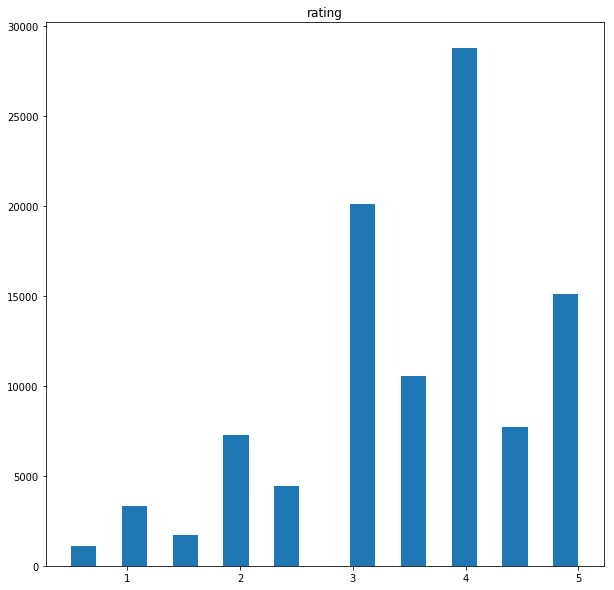

In [12]:
#Group users rating and movie id in a single table and plot a histogram
ratings.groupby('rating')['movieId'].nunique()
%matplotlib inline
ratings.hist(column='rating', figsize=(10,10), bins=20, grid=False)

getdvd       33
Ei muista    29
tivo         26
toplist07    26
toplist12    20
toplist11    20
tcm          20
toplist08    19
toplist15    19
toplist10    18
toplist14    18
toplist09    18
toplist06    16
holes00s     16
holes70s     16
Name: tag, dtype: int64

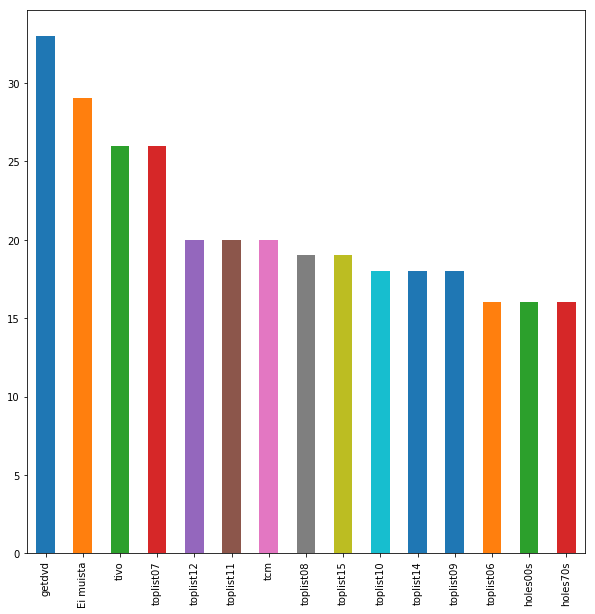

In [13]:
tag_counts=tags['tag'].value_counts()
tag_counts[:15]
tag_counts[:15].plot(kind='bar', figsize=(10, 10))

In [14]:
movies['movieId'].count()

9125

In [15]:
#step7: removing NaN values
genre_filter=(movies['genres']=='(no genres listed)')
movies=movies[~genre_filter]
movies=movies.reset_index(drop=True)

In [16]:
#step8: Checking Total genres present in DataSet
genres_count={}
for row in range(movies['movieId'].count()):
    for genre in movies['genres'][row].split("|"):
        if(genre !=''):
            genres_count[genre]=genres_count.get(genre, 0) + 1
genres_count

{'Action': 1545,
 'Adventure': 1117,
 'Animation': 447,
 'Children': 583,
 'Comedy': 3315,
 'Crime': 1100,
 'Documentary': 495,
 'Drama': 4365,
 'Fantasy': 654,
 'Film-Noir': 133,
 'Horror': 877,
 'IMAX': 153,
 'Musical': 394,
 'Mystery': 543,
 'Romance': 1545,
 'Sci-Fi': 792,
 'Thriller': 1729,
 'War': 367,
 'Western': 168}

<Container object of 19 artists>

([<matplotlib.axis.YTick at 0x24d596fe898>,
 <a list of 19 Text yticklabel objects>)

Text(0.5,0,'Movie Count')

Text(0.5,1,'Genre Popularity')

Text(1137,0.1,'1117')

Text(467,1.1,'447')

Text(603,2.1,'583')

Text(3335,3.1,'3315')

Text(674,4.1,'654')

Text(1565,5.1,'1545')

Text(4385,6.1,'4365')

Text(1565,7.1,'1545')

Text(1120,8.1,'1100')

Text(1749,9.1,'1729')

Text(897,10.1,'877')

Text(563,11.1,'543')

Text(812,12.1,'792')

Text(515,13.1,'495')

Text(173,14.1,'153')

Text(387,15.1,'367')

Text(414,16.1,'394')

Text(188,17.1,'168')

Text(153,18.1,'133')

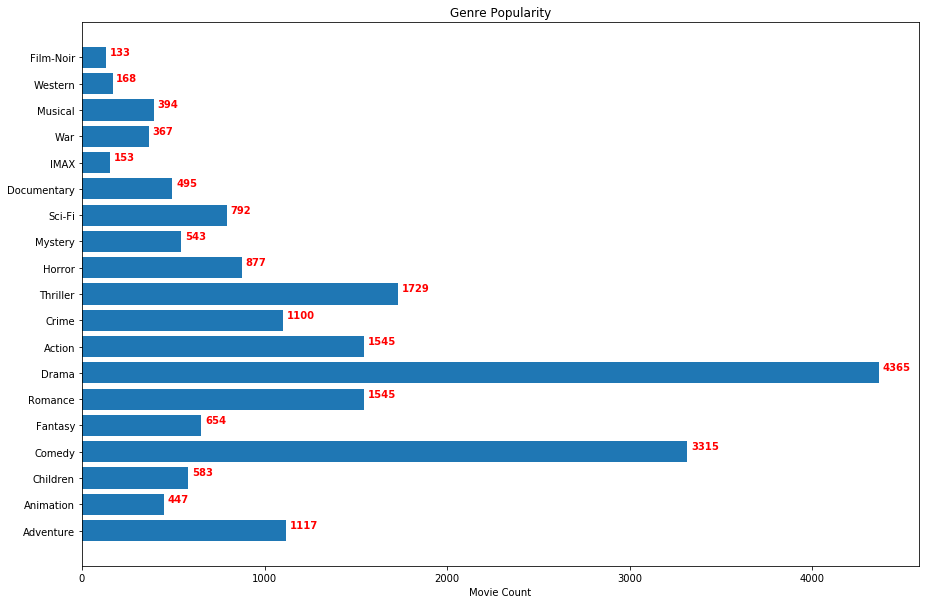

In [17]:
fig, ax=plt.subplots(figsize=(15, 10))
plt.barh(range(len(genres_count)), list(genres_count.values()))
plt.yticks(range(len(genres_count)), list(genres_count.keys()))
plt.xlabel('Movie Count')
plt.title('Genre Popularity')

for i, v in enumerate(genres_count.values()):
    ax.text(v  + 20, i + .10, v, color='red', fontweight='bold')

In [20]:
#step9: Euclidean Distance Score
def euclidean_distance(person1, person2):
    #getting details of person1 and person2
    df_first=ratings.loc[ratings['userId']==person1]
    df_second=ratings.loc[ratings.userId==person2]
    
    #find similar movie
    df= pd.merge(df_first, df_second, how='inner', on='movieId')
    if (len(df)==0): 
        return 0
    
    #sum of squared difference between ratings
    
    sum_of_squares=sum(pow((df['rating_x'] - df['rating_y']), 2))
    return 1/ (1+sum_of_squares)
#Checking by passing similar ID, correlation should be 1
euclidean_distance(1, 1)
    

1.0

In [25]:
#step 10: Pearson correlation Score
def pearson_score(person1, person2):
    #getting details of person1 and person2 
    df_first=ratings.loc[ratings.userId==person1]
    df_second=ratings.loc[ratings.userId==person2]
    
    #find similar rated movie
    df=pd.merge(df_first, df_second, how='inner', on='movieId')
    n=len(df)
    if n==0:
        return 0
    #adding all ratings
    sum1=sum(df['rating_x'])
    sum2=sum(df['rating_y'])
    
    #summing up all squared ratings
    sum1_square=sum(pow(df['rating_x'],2))
    sum2_square=sum(pow(df['rating_y'],2))
    
    #sum of product
    product_sum=sum(df['rating_x'] * df['rating_y'])
    
    #implementing pearson score
    numerator= product_sum - (sum1 * sum2/n)
    denominator=sqrt((sum1_square - pow(sum1, 2)/n) * (sum2_square - pow(sum2, 2)/n))
    
    if denominator==0: 
        return 0
    r=numerator/denominator
    return r
#Checking by passing similar ID, correlation should be 1
pearson_score(1,1)
    

    

1.0

In [26]:
#step11: Getting result based on pearson score
def topMatches(personId, n=5, similarity=pearson_score):
    scores=[(similarity(personId, other), other) for other in ratings.loc[ratings['userId']!=personId]['userId']]
    #highest score appear at the top
    scores.sort()
    scores.reverse()
    return scores[0:n]
topMatches(1, n=3)

[(1.0000000000000027, 177),
 (1.0000000000000027, 177),
 (1.0000000000000027, 177)]

In [ ]:
#Gets recommendations for a person by using a weighted average
def getRecommendation(personId, similarity=pearson_score):
    totals, simSums={}, {}
    df_person=ratings.loc[ratings.userId==personId]
    #all the user id except personId
    for otherId in ratings.loc[ratings['userId']!=personId]['userId']:
    
    #similarity with otherid
        sim=similarity(personId, otherId)
    
        if sim<=0: 
            continue
        
    df_other=ratings.loc[ratings.userId==otherId]
    
    #movie not seen by personId
    movie=df_other[~df_other.isin(df_person).all(1)]
    
    for movieid, rating in (np.array(movie[['movieId','rating']])):
        #similarity score
        totals.setdefault(movieid, 0)
        totals[movieid]+=rating*sim
        
        #sum of similarities
        simSums.setdefault(movieid, 0)
        simSums[movieid]+=sim
        
        #normalized list
        ranking=[(t/simSums[item], item) for item, t in totals.items()]
        
        #return the sorted list
        ranking.sort()
        ranking.reverse()
        recommendationId=np.array([x[1] for x in ranking])
        
        return np.array(movies[movies['movieId'].isin(recommendationId)]['title'])[:20]
    
# Example Recomendation
#20 recommended movie for the given UserID
# userId from 1 to 671
getRecommendation(1)
getRecommendation(671)

        

C:\Users\Sami\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars


array(['Toy Story (1995)'], dtype=object)